# Imports

In [50]:
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import pathlib as pl
import seaborn as sns
import cvxpy as cvx
import pandas as pd
import numpy as np
import math
import os
import requests
import re
import json

## Data extraction

In [ ]:
xdi_data = {}  # this will hold all our spectra

for n in range(1,258): #there exist 257 spectra
    response = requests.get(f'https://xaslib.xrayabsorption.org/spectrum/{n}/')
    soup = BeautifulSoup(response.text, 'html.parser')
    script = soup.find(id='xasplot').contents[1]
    name = soup.find('div', {'class': 'subtitle'}).text.rstrip('\n').split(':')[1].strip()

    # get javascript object inside the script
    model_data = re.search(r"var graph = ({.*?});", script.text, flags=re.S)
    model_data = model_data.group(1)

    obj = json.loads(model_data)
    x_vals = np.array(obj['data'][0]['x'])
    y_vals = np.array(obj['data'][0]['y'])
    peaks, _ = signal.find_peaks(y_vals, prominence=0.05, height=0.7)
    xdi_data[name] = {'x_vals': x_vals, 'y_vals': y_vals, 'x_peaks':x_vals[peaks], 'y_peaks':y_vals[peaks]}

In [ ]:
import pickle

fileObj = open('xdi_data.object', 'wb')
pickle.dump(xdi_data,fileObj)
fileObj.close()

## Data import

In [2]:
import pickle
with open('xdi_data.object', 'rb') as f:
    xdi_data = pickle.load(f)

# K- and R-Space visualisation

In [39]:
files = [x for x in pl.Path('.').glob('Co_Data/*/*')]

In [40]:
paths_k = [ x for x in pl.Path('.').glob('Co_Data/*/*k*')]
names_k = [ x.stem for x in pl.Path('.').glob('Co_Data/*/*k*')]
paths_R = [ x for x in pl.Path('.').glob('Co_Data/*/*R*')]
names_R = [ x.stem for x in pl.Path('.').glob('Co_Data/*/*R*')]

In [41]:
kedges = {}
for i, files in enumerate(paths_k):
    kedges[str(names_k[i])[:-6]] = pd.read_csv(files,sep='\s+', skiprows=38, header=None)

In [42]:
Rspace = {}
for i, files in enumerate(paths_R):
    Rspace[str(names_R[i])[:-6]] = pd.read_csv(files,sep='\s+', skiprows=38, header=None)

In [44]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(14)
axeslist = [(0,0),(0,1),(1,0), (1,1)]
labs = ['a) Co 15%',
        'b) Co 30%',
        'c) Co 45%',
        'd) Co 100%']
for i, p in enumerate(kedges):
    inds = axeslist[i]
    data = kedges[p].loc[:,(0,3)]
    data.columns = ['Wavenumber', 'X(k)']
    ax[inds].plot(data['Wavenumber'], data['X(k)'])
    ax[inds].set_xlabel(data.columns[0], fontsize=18)
    ax[inds].set_ylabel(data.columns[1], fontsize=18)
    ax[inds].text(0, min(data['X(k)']), s=labs[i], fontsize=18)
    ax[inds].tick_params(labelsize=14)
plt.savefig('figures/Four_undersampling_Kedge.png', dpi=250)

In [48]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(14)
axeslist = [(0,0),(0,1),(1,0), (1,1)]
labs = ['a) Co 15%',
        'b) Co 30%',
        'c) Co 45%',
        'd) Co 100%']
for i, p in enumerate(Rspace):
    inds = axeslist[i]
    # plot chi_R
    data = Rspace[p].loc[:,(0,1)]
    data.columns = ['Radial distance (Å)', '|X(R)| (A^(-3))']
    ax[inds].plot(data['Radial distance (Å)'], data['|X(R)| (A^(-3))'], color='red')
    # plot chir_mag
    rdata = Rspace[p].loc[:,(0,3)]
    rdata.columns = ['Radial distance (Å)', '|X(R)| (A^(-3))']
    ax[inds].plot(rdata['Radial distance (Å)'], rdata['|X(R)| (A^(-3))'], color='blue')
    ax[inds].set_xlabel(rdata.columns[0], fontsize=18)
    ax[inds].set_ylabel(r'$\ \vert X(R)\vert  (A^{-3} $)', fontsize=18)
    ax[inds].text(7, min(data['|X(R)| (A^(-3))']), s=labs[i], fontsize=18, va='bottom')
    ax[inds].tick_params(labelsize=14)
plt.savefig('figures/Four_undersampling_Rspace.png', dpi=250)

# Nickle oxidation states

In [51]:
data_dir = r'/Users/kili/Dropbox/My Mac (Kilian’s MacBook Air)/Documents/GitHub/xray_dl_reconstruction/databases/data/valid_data'

In [ ]:
my_list =['Ni metal', 'NiOH2', 'Ni2O3', 'NiS', 'NiSO4', 'Ni_metal']
[x for x in os.listdir(data_dir) if any(t in x for t in my_list)]

In [ ]:
oxidation_list = ['Ni_metal_rt_01.json',
                'NiOH2_rt_02.json',
                'Ni2O3_rt_02.json',
                'NiSO4_rt_01.json']

In [ ]:
datadict = {}
for filename in oxidation_list:
    with open(data_dir+'/'+filename) as f:
        datadict[filename] = json.load(f)

In [ ]:
datadict.keys()

dict_keys(['Ni_metal_rt_01.json', 'NiOH2_rt_02.json', 'Ni2O3_rt_02.json', 'NiSO4_rt_01.json'])

In [ ]:
a = pd.DataFrame([datadict['NiOH2_rt_02.json']['x_vals'], 
              datadict['NiOH2_rt_02.json']['y_vals']]).T
a.columns = ['x_vals', 'y_vals']
us = a.sample(frac=0.35).sort_index()

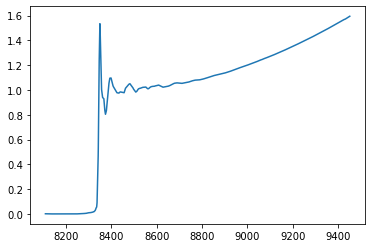

In [ ]:
plt.plot(us.x_vals, us.y_vals)

In [ ]:
sig, res = cs.compressive_reconstruction(us)

Target size is 608
Found a feasible x in R^608 that has 138 nonzeros.
optimal objective value: 69.54149934235782


In [ ]:
len(us.x_vals) / 0.25

608.0

In [ ]:
len(us.x_vals)

152

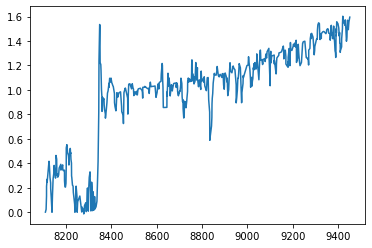

In [ ]:
plt.plot(res, sig)

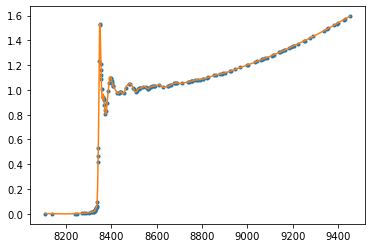

In [ ]:
plt.plot(us.x_vals, us.y_vals, '.')
plt.plot(a.x_vals, a.y_vals)

In [ ]:
for i in datadict:
    d = pd.DataFrame([datadict[i]['x_vals'], 
              datadict[i]['y_vals']]).T
    

Ni_metal_rt_01.json
NiOH2_rt_02.json
Ni2O3_rt_02.json
NiSO4_rt_01.json


In [ ]:
pd.DataFrame(datadict['Ni_metal_rt_01.json'])

In [ ]:
import cs

In [ ]:
cs.compressive_reconstruction()

TypeError: compressive_reconstruction() missing 1 required positional argument: 'sparse_signal'

## Do the iron

<AxesSubplot:>

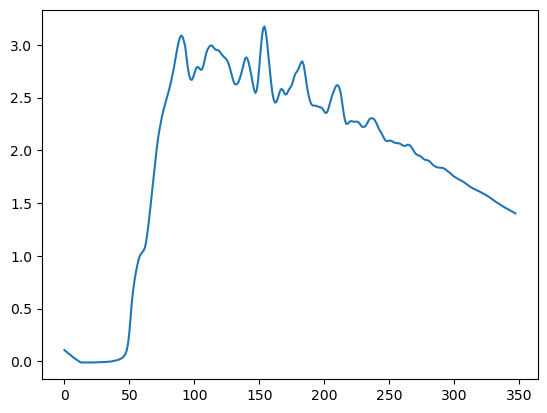

In [ ]:
df = pd.read_csv('/Users/kili/Dropbox/Unterlagen/Empa_Git/sparse-signal-recovery/data/Fe/Fe.csv', sep='\s+')
df['mutrans'].plot()

In [ ]:
from  scipy.fft import dct
import numpy as np
import matplotlib.pyplot as plt
N = len(df['mutrans'])
# Undersample the signal with 30% of the original data
M = N *0.45
# create undersampling matrix with ones and zeros
ri = np.random.choice(int(N), int(M), replace=False) # random sampling matrix
ri.sort()

# sampling matrix with random gaussian values between 0 and 1
np.random.rand(N)


# Compute the DCT
y = dct(df['mutrans'].values, norm='ortho')


#y_hat = (y + abs(min(y))) / (max(y)- min(y))
y_hat = y / sum(abs(y))
# get an array of zeros with the length of the original signal
x = np.zeros(N)
# set 1 at the indices of the random sampling matrix
x[ri] = 1

import math
coh = x * y_hat
max(coh)

0.027437865595718765

In [ ]:
# Load PSIs back from pickle
import pickle

n = 532
file = open('rip/PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)
file.close()

In [ ]:
import cs1
X  = np.array(df['mutrans'].values)
PHI, Omega = cs1.GetSensingMatrix(X.shape[0], 0.45)

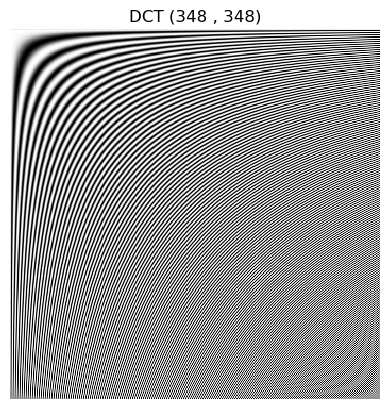

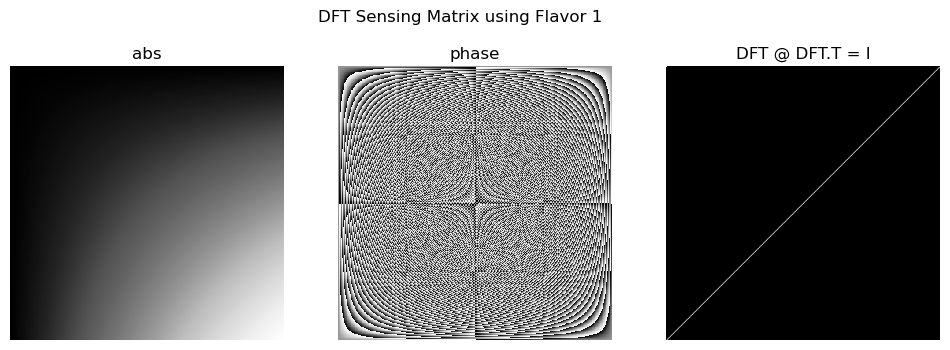

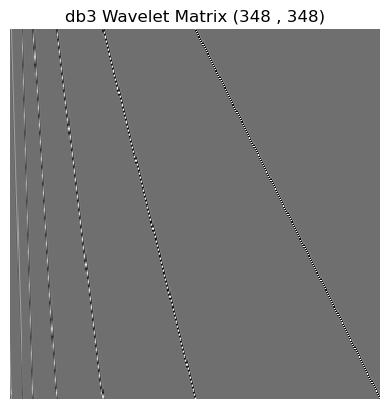

det(DWT_MTX) =  0.0
Expanded to  512 , Divide by 22.627416997969522
det(HWT_MTX) = 1.0


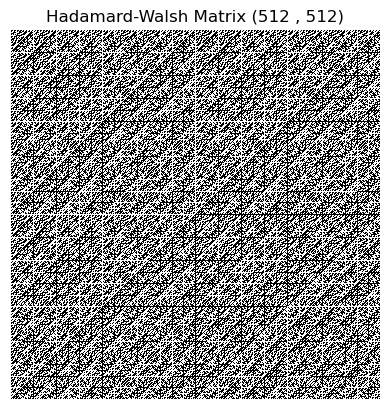

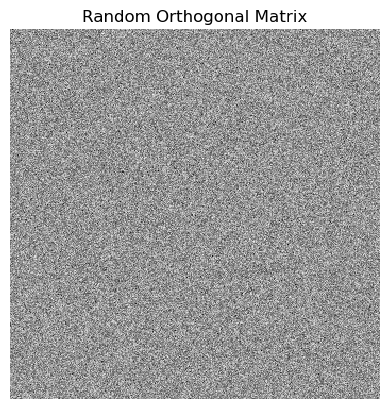

det(RVS_MTX) =  -1.0
saved to rip/PSIs_348.pkl


In [ ]:
import cs1.basis.common

n = X.shape[0]
cs1.basis.common.Generate_PSIs(n, savepath = 'rip/PSIs_' + str(n) + '.pkl')
# if you need to use transposed conj
for idx, key in enumerate(PSIs):
    PSIs[key] = PSIs[key].conj().T

In [ ]:

filehandler = open('PSIs_' + str(n) + '.pkl',"wb")
pickle.dump(PSIs, filehandler)
filehandler.close()


In [ ]:
n = X.shape[0]
file = open('rip/PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)

In [ ]:
file.close()
PSI = PSIs['DCT']
A = PHI @ PSI

In [ ]:
from cs1.metrics import *

mutual_coherence(PSI, Omega)

1.4142135623730951

In [ ]:
sparsity(X)

0.26453262562495683

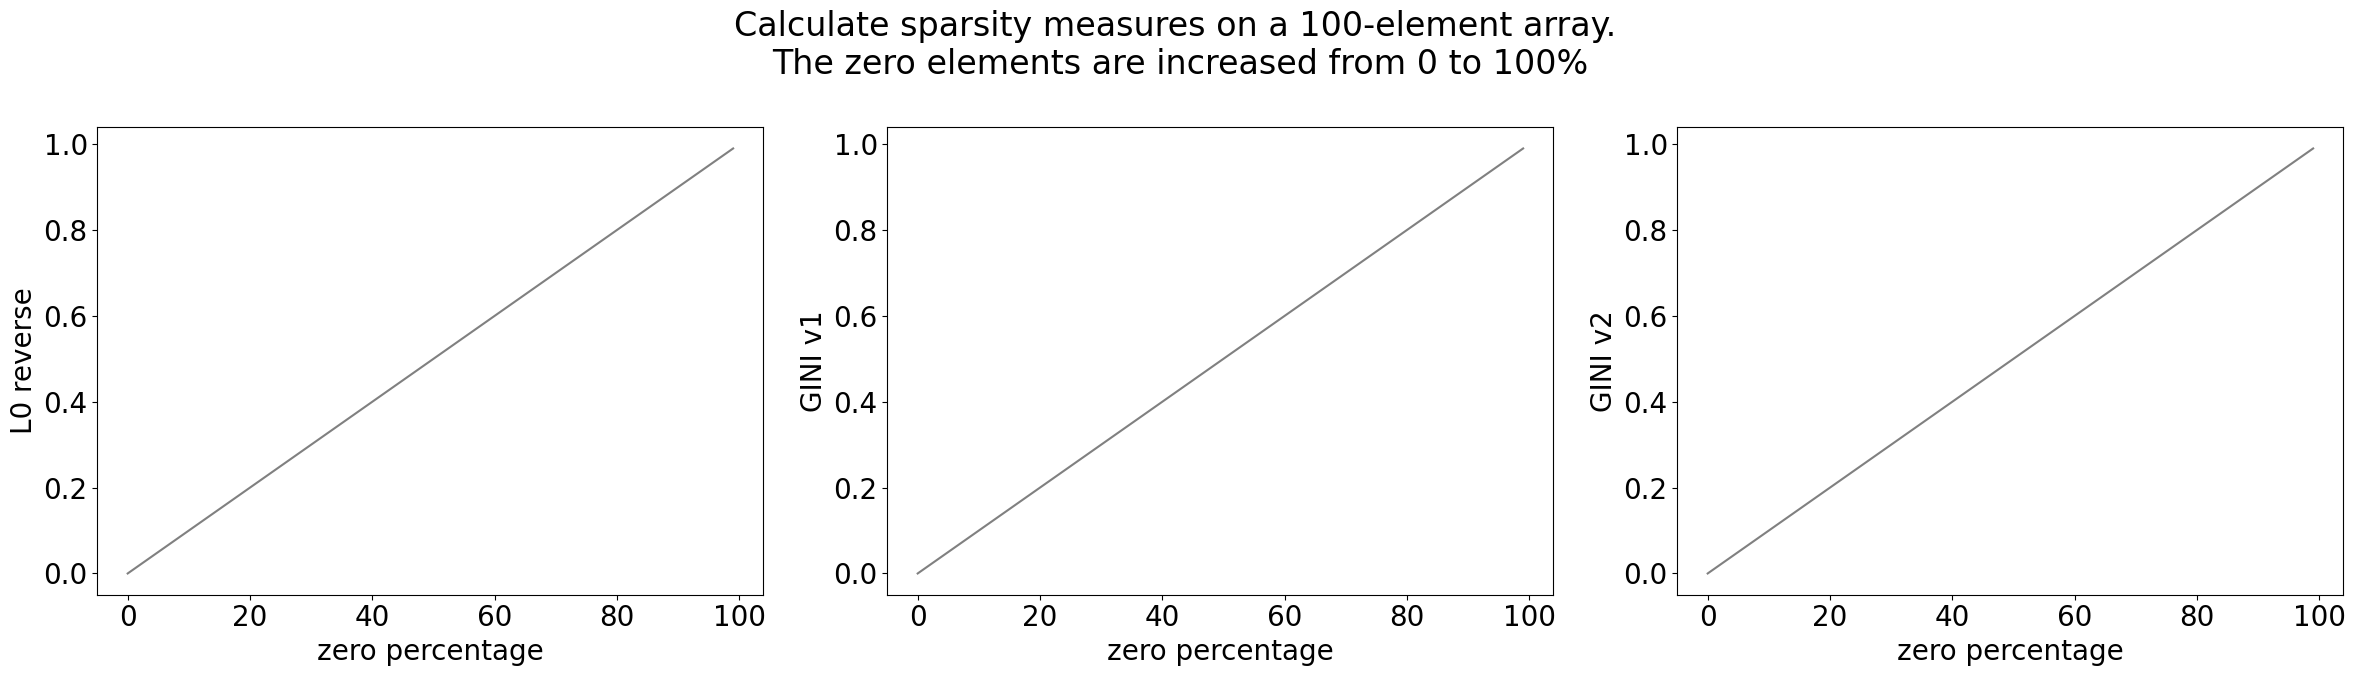

In [ ]:
compare_sparsity_flavors()

Mutual Coherence (IDM , OMEGA) :  18.65475810617763
Mutual Coherence (DCT , OMEGA) :  1.4142135623730951
Mutual Coherence (DFT , OMEGA) :  (1.000000000002574+4.701653339719397e-14j)
Mutual Coherence (DWT , OMEGA) :  15.052365924127008
Mutual Coherence (HWT , OMEGA) :  1.0
Mutual Coherence (ROM , OMEGA) :  4.316310444033187


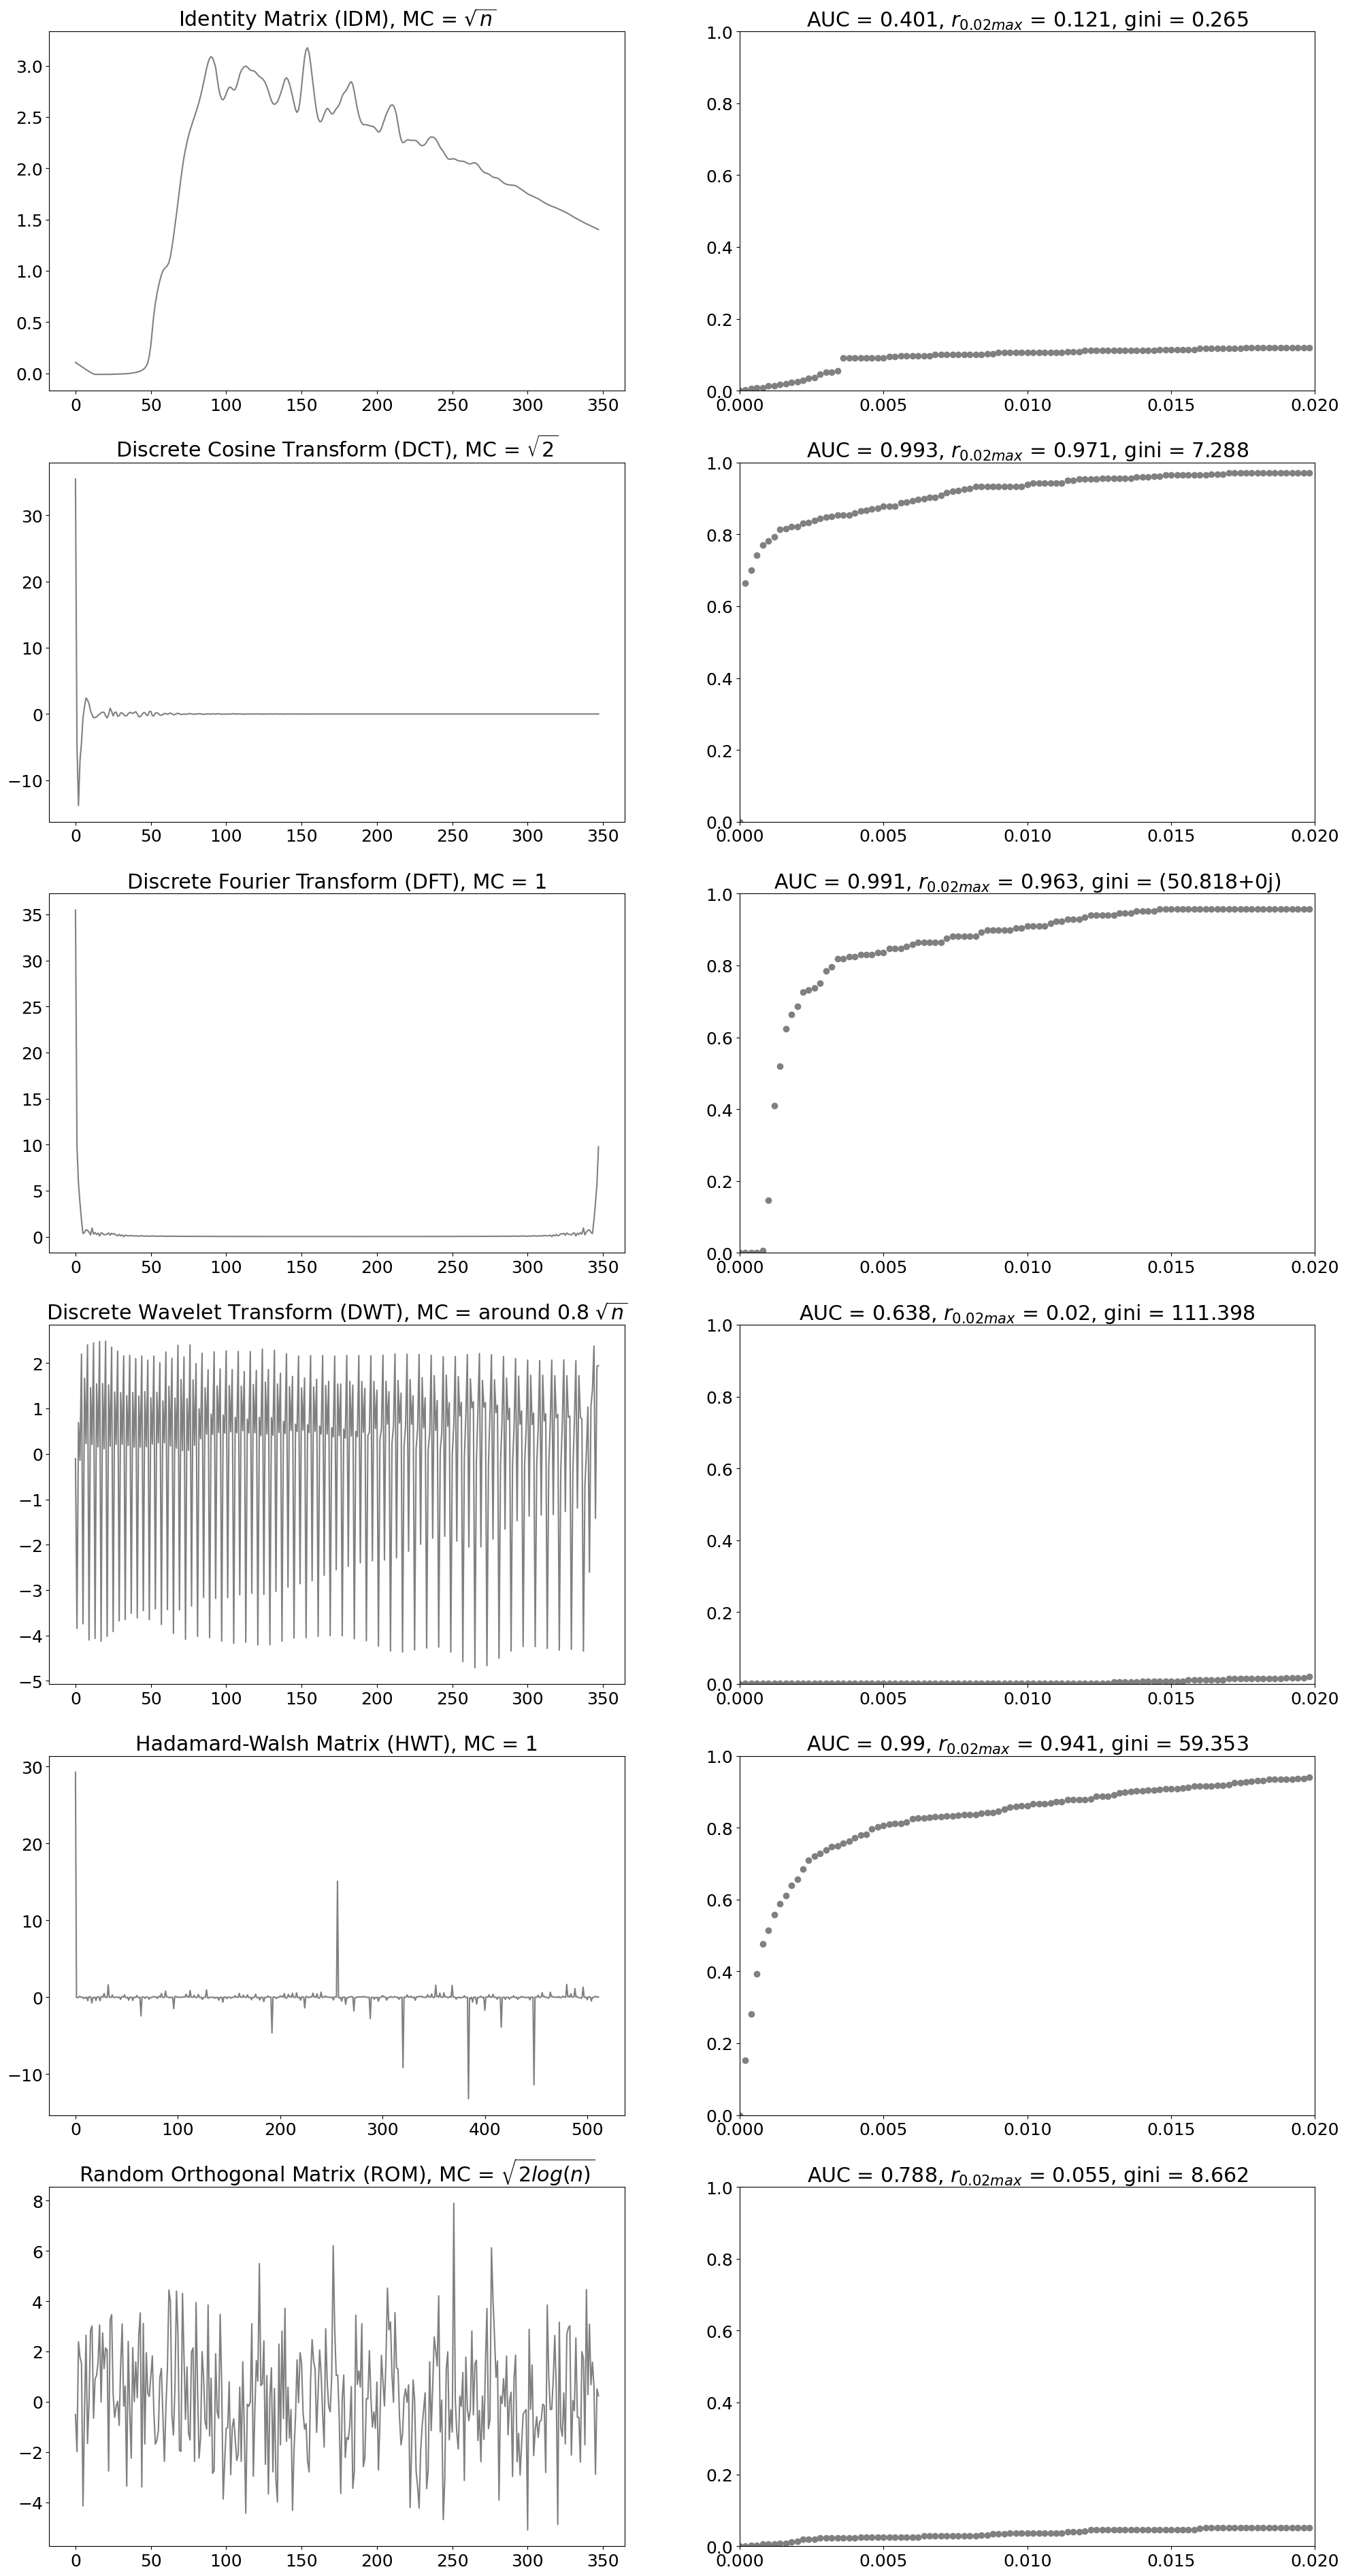

In [ ]:
analyze_sparsity(X, PSIs, compute_mc=True)

In [ ]:
len(dct(X)[dct(X) > 0]) / len(dct(X))

0.5258620689655172

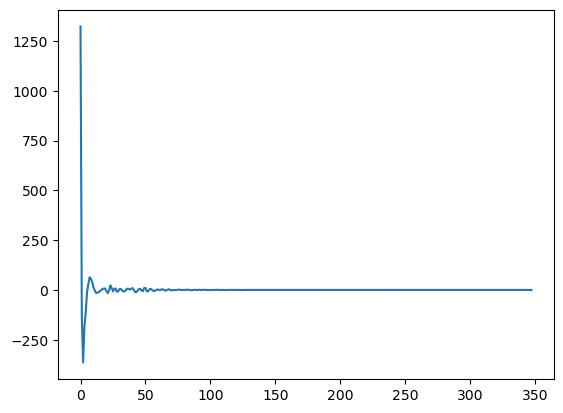

In [ ]:
plt.plot(dct(X))

In [ ]:
len(y[abs(y) > 0.01])

109

In [ ]:
0.4 **2 * (83) * math.log10(N) # lower bound

33.7521723596106

In [ ]:
0.4 **2 * (83) * math.log10(N) * 8.75 # upper bound

295.33150814659274

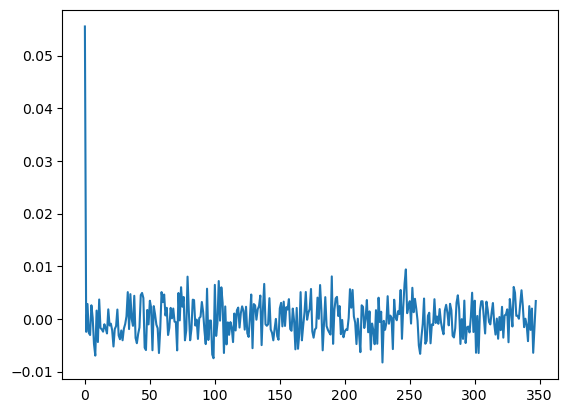

In [ ]:
xdct = dct(x, norm='ortho')
x_hat = xdct / sum(abs(xdct))

plt.plot(x_hat)

In [ ]:
import math
coh = x_hat * y_hat
max(coh)

0.022344363010189345

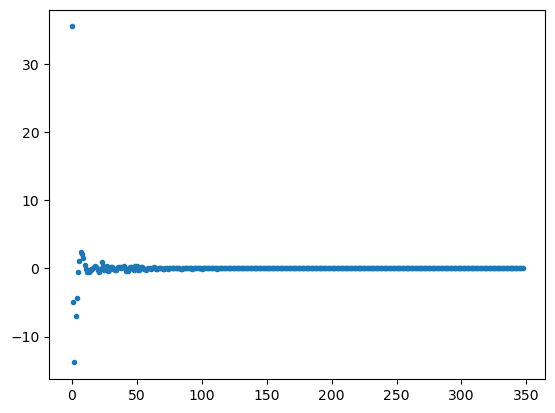

In [ ]:
plt.plot(y, '.')

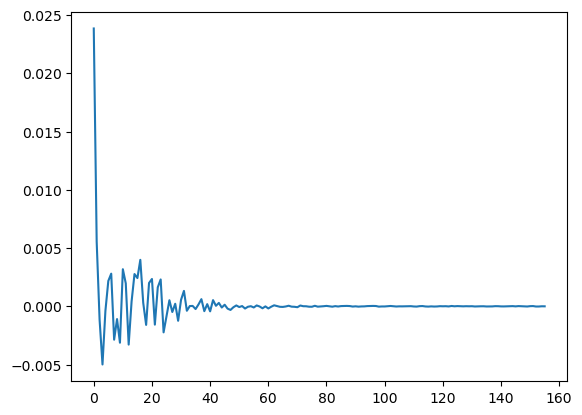

In [ ]:
plt.plot(y_hat[ri])

# Cumulative Plot

In [53]:
my_list = [
    'V_foil',
    'cro2_rt_001',
    'Mn3O4_rt_01',
    'co_metal_rt',
    'Ni_metal_rt_01',
    'Cu_Foil_rt_2016Foils_13IDE_01'
]

In [54]:
nice_list = [
    'Vanadium (V)',
    'Chromium-Oxide (CrO2)',
    'Manganese-Oxide (Mn3O4)',
    'Cobalt (Co)',
    'Nickle (Ni)',
    'Copper (Co)'
]

In [56]:
import matplotlib.pyplot as plt
from numpy import diff 

colors = ['red', 'blue', 'brown', 'green', 'skyblue', 'orange']
i = 250
p = 0
fig = plt.figure(figsize=(8,5), dpi=400)
for x in xdi_data:
    if x in my_list:
        from numpy import diff
        data = xdi_data[x]['x_vals']-xdi_data[x]['x_vals'].min()
        dx = diff(data)
        dx = diff(dx)
        point = abs(dx).argmax()
        point2 = abs(dx)[abs(dx).argmax()+1:].argmax()+point+1
        plt.scatter( data[point], point, c=colors[p],label='_nolegend_')
        plt.scatter( data[point2], point2, c=colors[p], label='_nolegend_')
        plt.plot(data, range(len(xdi_data[x]['x_vals'])),c=colors[p])
        p+=1
    if i == 0:
        break
    i -=1
plt.legend(nice_list, fontsize=13)
plt.xlabel('ΔE (E - $E_{min}$) (eV)', fontsize=14)
plt.ylabel('Cumulative number of data points', fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('figures/cumulative_upgraded.png', dpi=300, bbox_inches='tight')

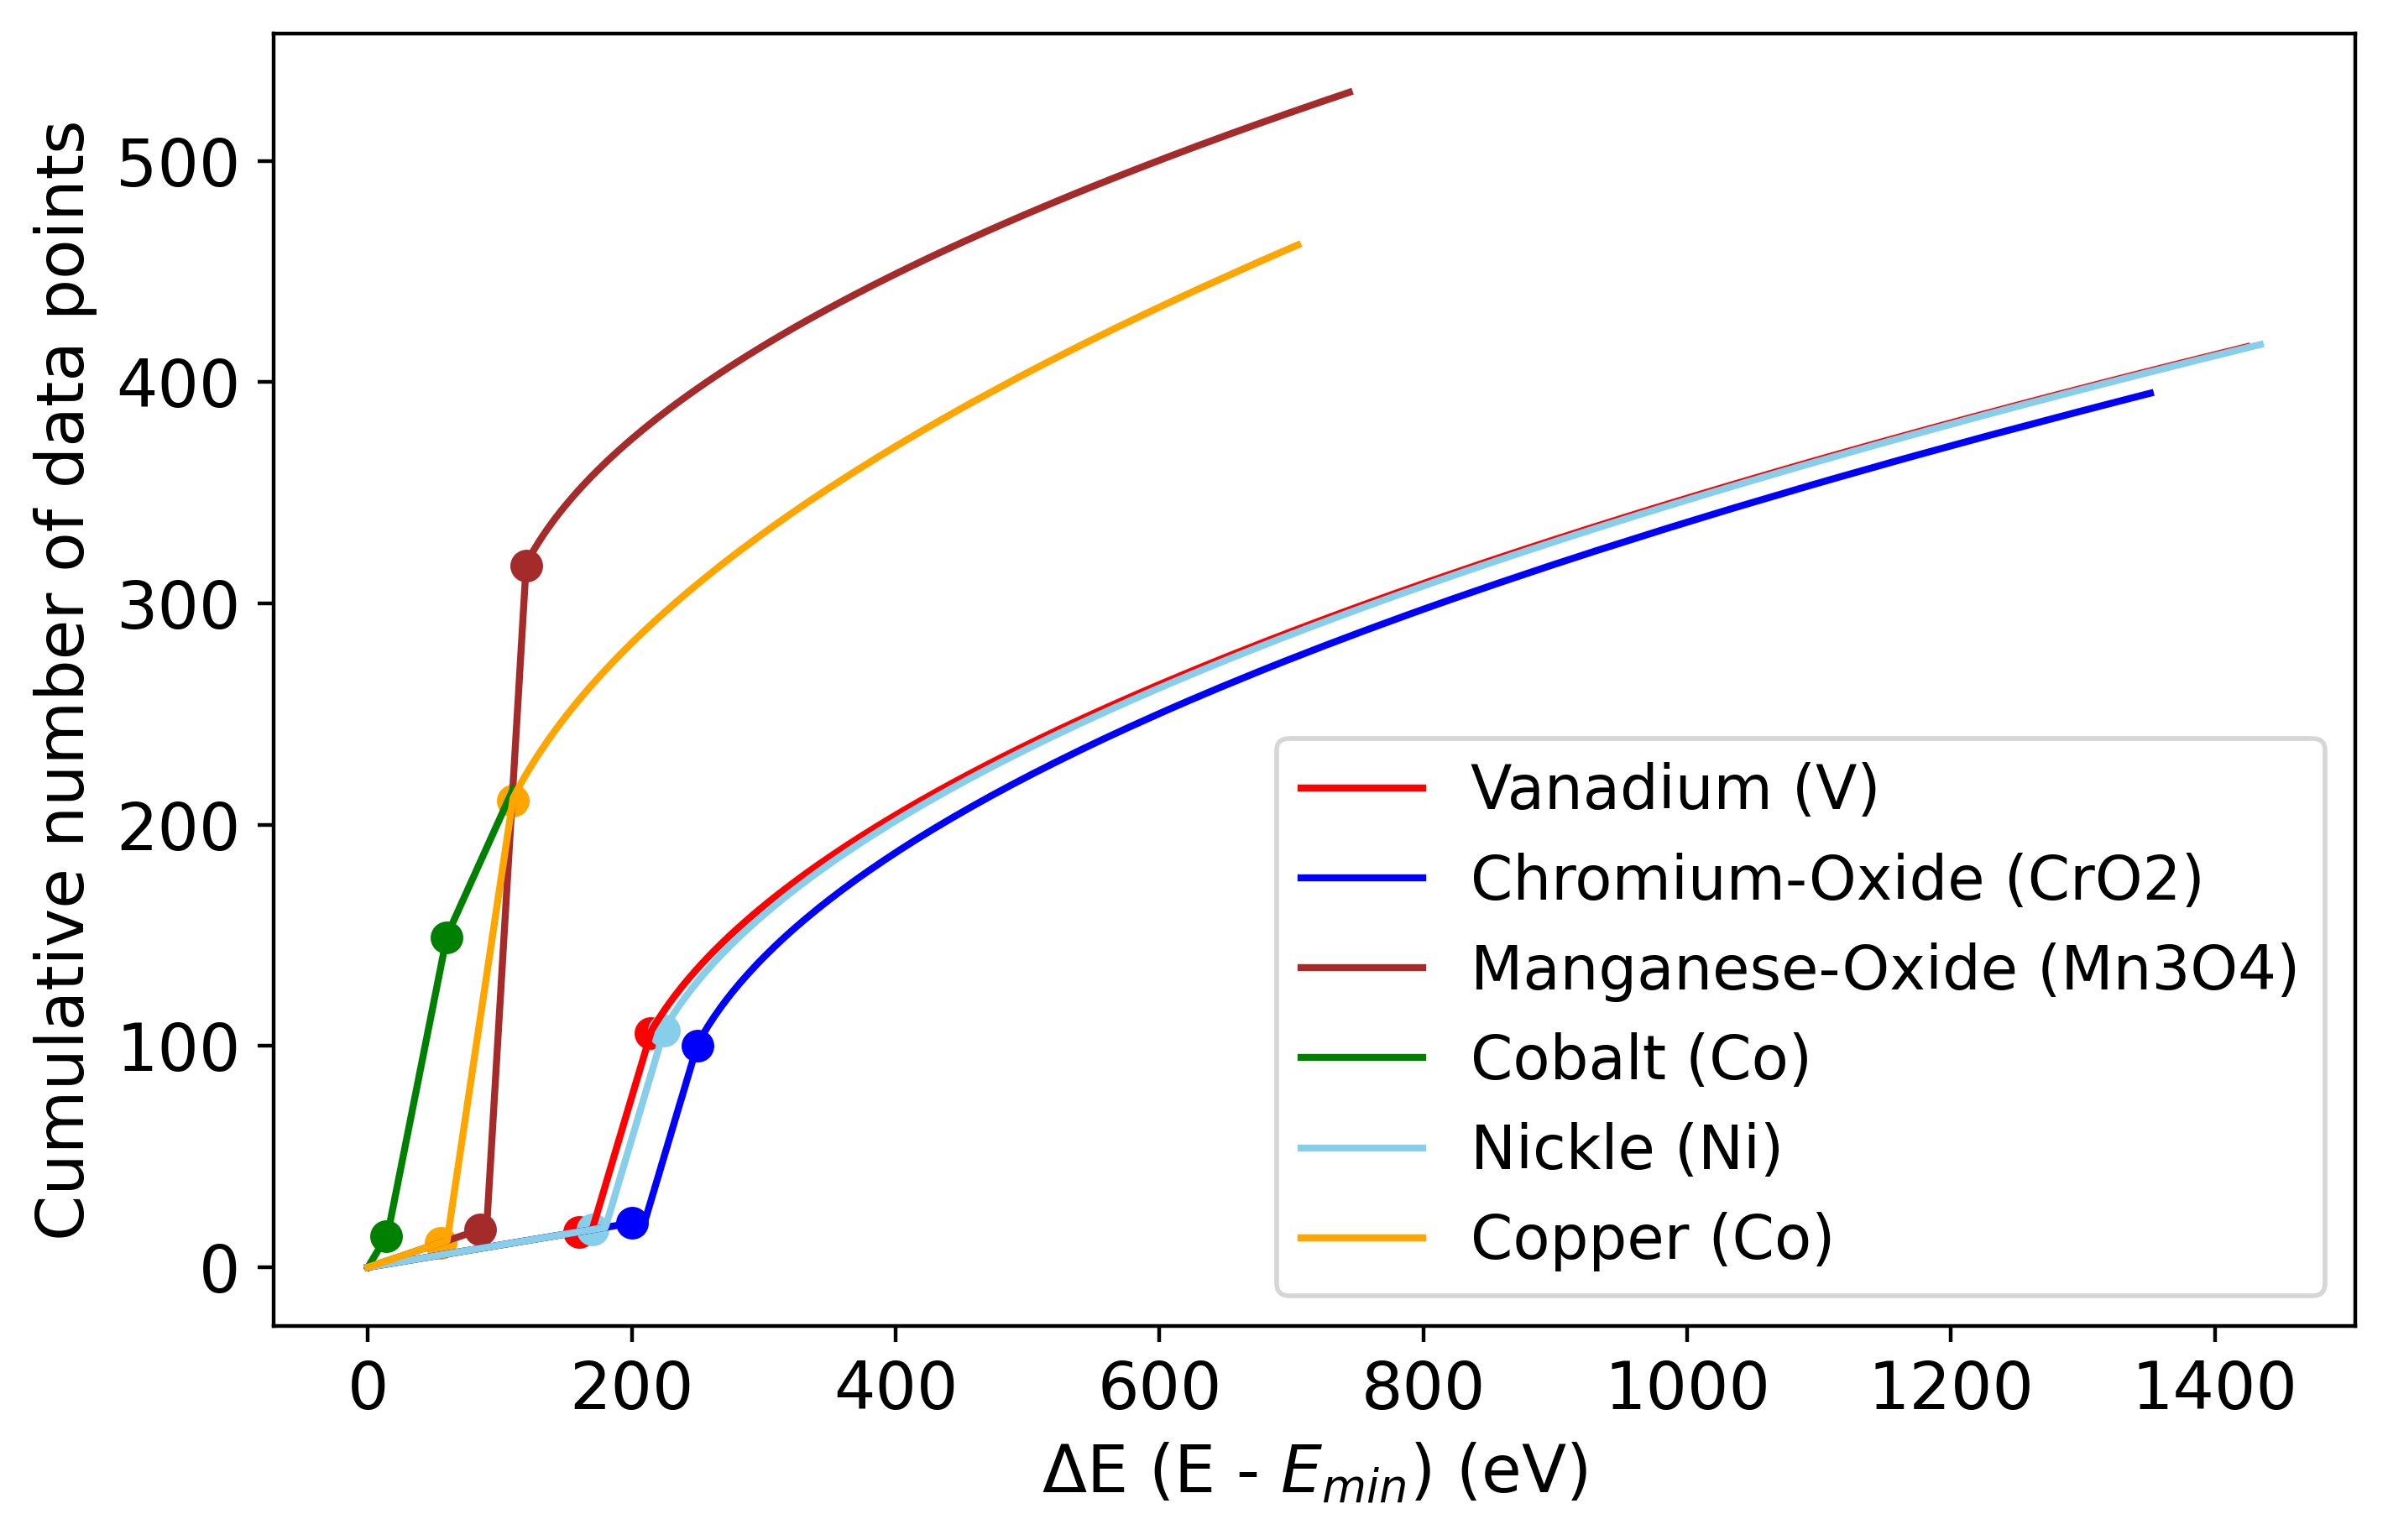

In [ ]:
plt.show()

# Compare different solving algorithms

## Import data & transform

In [57]:
original_data = pd.read_csv(r"./Fe.csv", sep = '\s+')

x_Data = original_data['energy']
y_Data = original_data['mutrans']
n = len(x_Data) # original resolution

print(x_Data.shape)
print(y_Data.shape)
print(f'Original Length: {n}')

(348,)
(348,)
Original Length: 348


In [58]:
# normalize y_Data with min-max normalization
y_Data =( y_Data - np.min(y_Data)) / (np.max(y_Data) - np.min(y_Data))

In [59]:
# verify the maximum value is 1
y_Data.max()

1.0

In [60]:
data = pd.DataFrame([x_Data, y_Data]).T

In [61]:
# randomly undersample with set seed
undersampling = 0.45
np.random.seed(0) # seed
ri = np.random.choice(n, int(n*(undersampling)), replace=False)
ri.sort()
print(f'Randomly sampled length with an Undersampling of {undersampling} is {len(ri)}')

uSx = x_Data[ri].astype(int) #undersampled X
uSy = y_Data[ri]             #undersampled Y

Randomly sampled length with an Undersampling of 0.45 is 156


## Solve one example

In [62]:
# prepare measurement Matrix B
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
B = A[ri]

In [63]:
# do L1 optimization
vx = cvx.Variable(len(x_Data))
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [B@vx == uSy]
prob = cvx.Problem(objective, constraints)
result = prob.solve(solver='ECOS', verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Feb 15 09:44:10 AM: Your problem has 348 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 15 09:44:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 15 09:44:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 15 09:44:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 15 09:44:10 AM: Compiling problem (target solver=ECOS).
(CVXPY) Feb 15 09:44:10 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

In [64]:
# plot reconstructed signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
plt.plot(x_Data, sig)
plt.plot(x_Data, y_Data)

In [65]:
# calculate the MSE
mse = ((y_Data - sig) ** 2).mean(axis=None) # mean squared error
print(mse)

0.00015305136130583507


## Do reconstruction with different solvers and compare the performance

In [66]:
# preparation function
def prepare_cs(n, undersampling, seed):
    np.random.seed(seed)
    ri = np.random.choice(n, int(n*(undersampling)), replace=False)
    ri.sort()
    A = spfft.idct(np.identity(n), norm='ortho', axis=0)
    uSx = x_Data[ri].astype(int) #undersampled X
    uSy = y_Data[ri]             #undersampled Y
    B = A[ri]
    return B, uSy, uSx

In [67]:
# wrapper to time the functions
def timeit_wrapper(func, *args, **kwargs):
    from datetime import timedelta
    import time
    def wrap(*args, **kwargs):
        starttime = time.perf_counter()
        error = func(*args, **kwargs)
        duration = timedelta(seconds=time.perf_counter()-starttime)
        return duration, error
    return wrap

In [68]:
# General function
@timeit_wrapper
def optimize(n, y_Data, undersampling:float, solver, errors:[], 
             params:dict(), save:bool, plot:bool=False, seed=None):
    B, uSy, uSx = prepare_cs(n, undersampling, seed=seed)
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [B@vx == uSy]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(solver=solver, verbose=False, **params)
    x = np.array(vx.value)
    x = np.squeeze(x)
    sig = spfft.idct(x, norm='ortho', axis=0)
    mse = ((y_Data - sig) ** 2).mean(axis=None) # mean squared error
    errors.append(mse)
    
    if plot:
        plt.plot(x_Data, sig)
        plt.plot(x_Data, y_Data, alpha=0.7)
        plt.title(solver)
        plt.xlabel('Energy (eV)')
        plt.ylabel('Absorption Coefficient (μ)')
        plt.text(7550, 2.5, "Error: {:.2e}".format(mse))
        plt.legend(['Reconstructed Signal', 'Original Signal'])
    if save:
        plt.savefig(f'./figures/{int(undersampling*100)}/{solver}_{str(undersampling)}.png', dpi=250)
    if plot:
        plt.show()
    return mse

In [69]:
# OMP
@timeit_wrapper
def optimize_OMP(n, undersampling:float, y_Data, solver, errors:[], params:dict(), save:bool, plot:bool=False, seed=None):
    from sklearn.linear_model import OrthogonalMatchingPursuit
    import random
    B, uSy, uSx = prepare_cs(n, undersampling, seed=seed)
    # Define the original signal with 348 points
    original_signal_length = n
    original_signal = y_Data  # You can replace this with your actual signal

    # Define the undersampling rate (45% in this case)
    undersampling_rate = undersampling

    # Calculate the number of measurements
    num_measurements = int(original_signal_length * undersampling_rate)

    # Create the measurement matrix (DCT matrix)
    from scipy.fftpack import dct, idct
    dct_matrix = dct(np.identity(original_signal_length), norm='ortho')

    # Generate random indices for undersampling
    undersampled_indices = np.random.choice(original_signal_length, num_measurements, replace=False)

    # Create the undersampled signal
    undersampled_signal = original_signal[undersampled_indices]

    # Initialize the OMP model
    omp = OrthogonalMatchingPursuit(fit_intercept=False, **params)  # You can adjust the number of nonzero coefficients  n_nonzero_coefs=50,

    # Fit the OMP model to the undersampled signal
    omp.fit(dct_matrix[undersampled_indices, :], undersampled_signal)

    # Reconstruct the signal using the OMP coefficients
    reconstructed_signal = np.dot(dct_matrix, omp.coef_)

    if plot:
        # Print the reconstructed signal
        # Plot the original and reconstructed signals
        plt.figure()
        plt.plot(original_signal, label='Original Signal')
        plt.plot(reconstructed_signal, label='Reconstructed Signal')
        plt.legend()
        plt.title('Original vs. Reconstructed Signal')
        plt.show()
    mse = ((y_Data - reconstructed_signal) ** 2).mean(axis=None) # mean squared error
    errors.append(mse)
    return mse

In [70]:
# LASSO
@timeit_wrapper
def optimize_LASSO(n, undersampling:float, y_Data, solver, errors:[], params:dict(), save:bool, plot:bool=False, seed=None):
    from sklearn.linear_model import Lasso
    import random
    B, uSy, uSx = prepare_cs(n, undersampling, seed=seed)
    # Define the original signal with 348 points
    original_signal_length = n
    original_signal = y_Data  # Replace this with your actual signal

    # Define the undersampling rate (45% in this case)
    undersampling_rate = undersampling

    # Calculate the number of measurements
    num_measurements = int(original_signal_length * undersampling_rate)

    # Create the measurement matrix (DCT matrix)
    from scipy.fftpack import dct, idct
    dct_matrix = dct(np.identity(original_signal_length), norm='ortho')

    # Generate random indices for undersampling
    undersampled_indices = np.random.choice(original_signal_length, num_measurements, replace=False)

    # Create the undersampled signal
    undersampled_signal = original_signal[undersampled_indices]

    # Initialize the LASSO model
    lasso = Lasso(alpha=0.00005, fit_intercept=False, **params)  # You can adjust the regularization strength (alpha)

    # Fit the LASSO model to the undersampled signal
    lasso.fit(dct_matrix[undersampled_indices, :], undersampled_signal)

    # Reconstruct the signal using LASSO coefficients
    reconstructed_signal = lasso.coef_.dot(dct_matrix.T)

    if plot:
        # Print the reconstructed signal
        # Plot the original and reconstructed signals
        plt.figure()
        plt.plot(original_signal, label='Original Signal')
        plt.plot(reconstructed_signal, label='Reconstructed Signal')
        plt.legend()
        plt.title('Original vs. Reconstructed Signal (LASSO)')
        plt.show()
        
    mse = ((y_Data - reconstructed_signal) ** 2).mean(axis=None) # mean squared error
    errors.append(mse)
    return mse

In [76]:
import pickle
repetitions = 2000
undersampling = 0.45
solvers = ['ECOS', 'SCS', 'OSQP'] #'MOSEK'
# give a list of 200 random numbers between 0 and 1000 using np.random
np.random.seed(0)
seeds = np.random.choice(2*repetitions, repetitions, replace=False)
results = dict()
for solver in solvers:
    results[solver] = dict()
    results[solver]['Error'] = []
    results[solver]['Time'] = []
    
for repetition in range(repetitions):
    for solver in solvers:
        time_used, error = optimize(n, y_Data, undersampling, solver, [], {}, False, False, seed=seeds[repetition])
        results[solver]['Time'].append(time_used)
        results[solver]['Error'].append(error)
        
fortyfive = results
pickle.dump(fortyfive, open(f'./output_data/fortyfive.pkl', 'wb'))

In [ ]:
repetitions = 2000
undersampling = 0.3
solvers = ['ECOS', 'SCS', 'OSQP'] #'MOSEK'
# give a list of 200 random numbers between 0 and 1000 using np.random
np.random.seed(0)
seeds = np.random.choice(2*repetitions, repetitions, replace=False)
results = dict()
for solver in solvers:
    results[solver] = dict()
    results[solver]['Error'] = []
    results[solver]['Time'] = []
    
for repetition in range(repetitions):
    for solver in solvers:
        time_used, error = optimize(n, y_Data, undersampling, solver, [], {}, False, False, seed=seeds[repetition])
        results[solver]['Time'].append(time_used)
        results[solver]['Error'].append(error)
        
thirty = results
pickle.dump(thirty, open(f'./output_data/thirty.pkl', 'wb'))

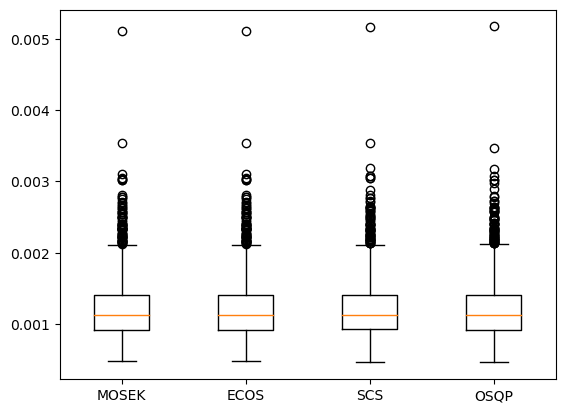

In [319]:
plt.boxplot(errors.values(), labels=errors.keys());

In [131]:
def reconstruct(undersampling:float, 
                seed:int, 
                x_Data, 
                y_Data, 
                opt_params, 
                reps:int,
                save_bool:bool,
                solvers:list() = ['MOSEK','ECOS','ECOS_BB', 'SCS', 'OSQP', 'OMP', 'LASSO'], 
                plot_bool:bool = False,
                sleep:bool=True):
    
    import time
    import timeit
    import random
    from functools import partial
    from statistics import median
    n = len(x_Data)
    B, uSy, uSx = prepare_cs(n, undersampling, seed)
    print(f'Randomly sampled length with an Undersampling of {undersampling} is {len(uSx)}')

    plt.plot(x_Data, range(len(x_Data)), '-')
    plt.plot(uSx, range(len(uSx)),'.', markersize=3)
    plt.title("Sampling frequency of sampled x-Data (.) and original x-Data (-)")
    plt.xlabel('Energy (eV)')
    plt.ylabel('Sampling count')
    
    plt.legend(['Signal of interest', 'Measurement Matrix'])
    if save_bool:
        plt.savefig(f'./Figures/{int(undersampling*100)}/sampling_frequency_{int(undersampling*100)}.png', dpi=250)
    plt.show()

    plt.plot(x_Data, y_Data)
    plt.plot(uSx, uSy, '.', color = 'red', markersize=3)
    plt.title("Undersampled (red) and original (blue) data")
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption Coefficient (μ)')
    plt.text(7550, 0.5, f'{undersampling*100} % Sampling')

    if save_bool:
        plt.savefig(f'./Figures/{int(undersampling*100)}/Undersampled_vs_original_Data_{int(undersampling*100)}.png', dpi=250)
    plt.show()

    results = dict()
    random.seed = seed
    for solver in solvers:
        if solver == 'OMP':
            errors = []
            print(f'Solving with solver {solver} and Parameters {opt_params}')
            result = timeit.repeat(partial(optimize_OMP, n, undersampling, y_Data, solver, errors,opt_params,save=save_bool, plot=False),number=reps, repeat=2000)
            optimize_OMP(n, undersampling, y_Data, solver, errors, opt_params, plot=plot_bool,save=save_bool)
        elif solver == 'LASSO':
            errors = []
            print(f'Solving with solver {solver} and Parameters {opt_params}')
            result = timeit.repeat(partial(optimize_LASSO, n, undersampling=undersampling,
                                           y_Data=y_Data, solver=solver, errors=errors, params=opt_params,save=save_bool, plot=False),number=reps, repeat=2000)
            optimize_LASSO(n,undersampling, y_Data, solver, errors, opt_params, plot=plot_bool, save=save_bool)
        else:
            errors = []
            print(f'Solving with solver {solver} and Parameters {opt_params}')
            result = timeit.repeat(partial(optimize, n=n, undersampling=undersampling, 
                                           y_Data=y_Data, solver=solver, errors=errors,params=opt_params,save=save_bool, plot=False),number=reps, repeat=2000)
            optimize(n=n, undersampling=undersampling, y_Data=y_Data, solver=solver, errors=errors, params=opt_params, plot=plot_bool, save=save_bool)
            
        
        print(f"Error \t Min:\t{min(errors):.5f}, Max:\t{max(errors):.5f}, Median:\t{median(errors):.5f}, Mean:\t{sum(errors)/len(errors):.5f}")
        print("-----------------------------------------------------------------------------")
        print(f"Time (s) \t Min:\t{(min(result)/reps):.5f}, Max:\t{(max(result)/reps):.5f}, Median:\t{(median(result)/reps):.5f}")
        results[solver] = {'Error': errors,
                           'Time': result}
        
        if sleep: time.sleep(60)
    
    return results
        

## Compare

Randomly sampled length with an Undersampling of 0.3 is 104


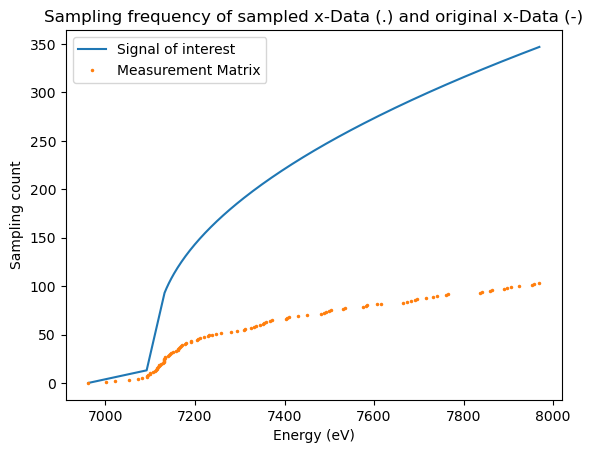

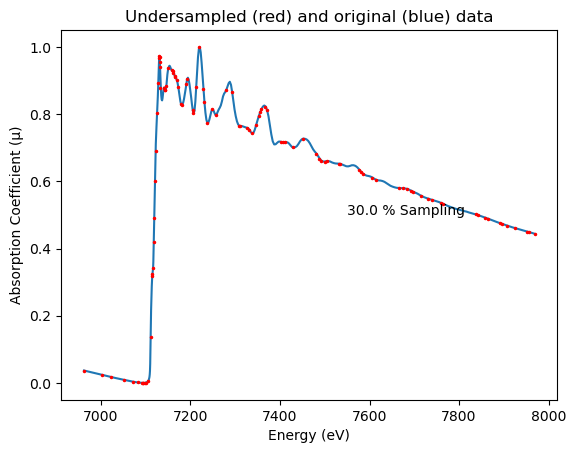

Solving with solver MOSEK and Parameters {}
Error 	 Min:	0.00056, Max:	0.00310, Median:	0.00119, Mean:	0.00126
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.07982, Max:	0.76979, Median:	0.12385
Solving with solver SCS and Parameters {}
Error 	 Min:	0.00053, Max:	0.00354, Median:	0.00108, Mean:	0.00119
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.31442, Max:	5.75039, Median:	0.61772
Solving with solver ECOS and Parameters {}
Error 	 Min:	0.00048, Max:	0.00250, Median:	0.00112, Mean:	0.00120
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.08212, Max:	0.32687, Median:	0.09410
Solving with solver OSQP and Parameters {}
Error 	 Min:	0.00058, Max:	0.00250, Median:	0.00112, Mean:	0.00122
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.19673, Max:	0.83602, Median:	0.37134


In [113]:
thirty = reconstruct(0.30, 1, x_Data, y_Data, plot_bool=False, opt_params={}, solvers=['MOSEK', 'SCS', 'ECOS', 'OSQP'], reps=1, save_bool=False, sleep=False)

Randomly sampled length with an Undersampling of 0.45 is 156


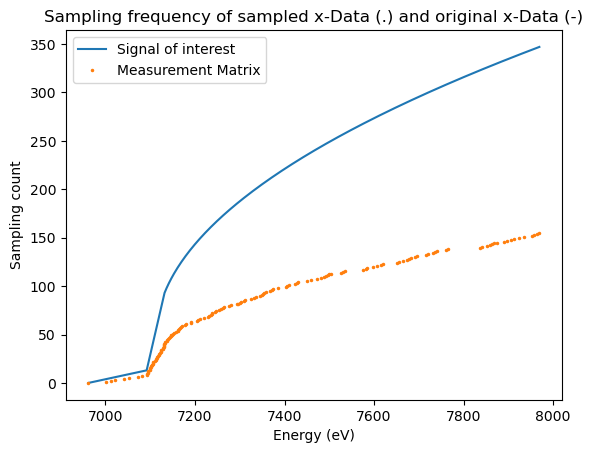

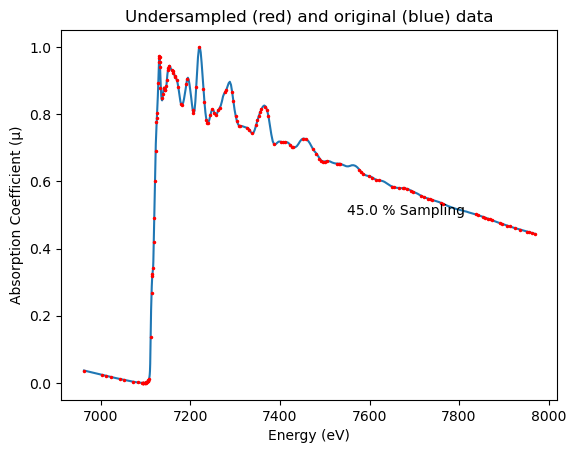

Solving with solver MOSEK and Parameters {}
Error 	 Min:	0.00005, Max:	0.00082, Median:	0.00027, Mean:	0.00029
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.07153, Max:	0.10095, Median:	0.08082
Solving with solver SCS and Parameters {}
Error 	 Min:	0.00004, Max:	0.00103, Median:	0.00028, Mean:	0.00029
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.39508, Max:	1.18399, Median:	0.69053
Solving with solver ECOS and Parameters {}
Error 	 Min:	0.00005, Max:	0.00133, Median:	0.00024, Mean:	0.00028
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.09381, Max:	1.23921, Median:	0.10576
Solving with solver OSQP and Parameters {}
Error 	 Min:	0.00005, Max:	0.00078, Median:	0.00025, Mean:	0.00028
-----------------------------------------------------------------------------
Time (s) 	 Min:	0.27036, Max:	2.02144, Median:	0.43551


In [115]:
fortyfive = reconstruct(0.45, 1, x_Data, y_Data, plot_bool=False, opt_params={}, 
                        solvers=['MOSEK', 'SCS', 'ECOS', 'OSQP'], 
                        reps=1, save_bool=False, sleep=False)

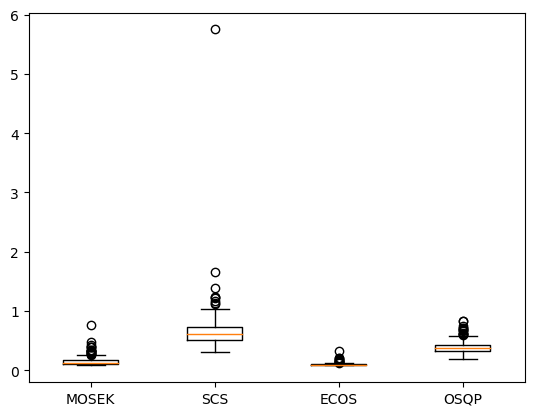

Text(0, 0.5, 'Time (s) per computation')

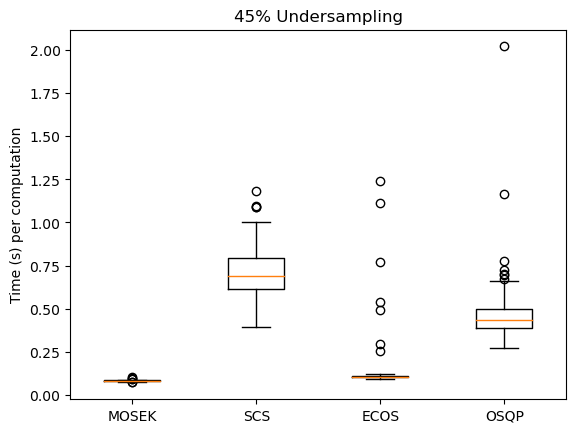

In [130]:
plt.boxplot([x['Time'] for x in thirty.values()], labels=thirty.keys());
plt.show()
plt.boxplot([x['Time'] for x in fortyfive.values()], labels=fortyfive.keys());
plt.title('45% Undersampling')
plt.ylabel('Time (s) per computation')

Text(0, 0.5, 'Mean squared error')

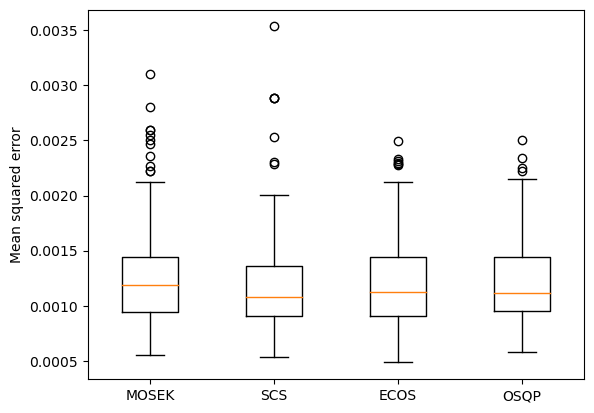

In [127]:
plt.boxplot([x['Error'] for x in thirty.values()], labels=thirty.keys());
plt.ylabel('Mean squared error')

In [29]:
timeviolin = pd.DataFrame()
for methods in thirty.keys():
    temp = pd.DataFrame(np.array(thirty[methods]['Time']), columns=['Time'])
    temp['Solver'] = methods
    temp['Undersampling'] = '30 %'
    timeviolin = pd.concat([timeviolin, temp])

In [30]:
for methods in fortyfive.keys():
    temp = pd.DataFrame(np.array(fortyfive[methods]['Time']), columns=['Time'])
    temp['Solver'] = methods
    temp['Undersampling']  = '45 %'
    timeviolin = pd.concat([timeviolin, temp])

In [31]:
timeviolin.reset_index(inplace=True, drop=True)

In [20]:
import datetime
timeviolin.Time[0].total_seconds()

0.199203

In [32]:
timeviolin.Time = timeviolin.Time.apply(lambda x: x.total_seconds())

In [35]:
timeviolin.groupby(['Solver', 'Undersampling']).count()

Time
Solver Undersampling      
ECOS   30 %           2000
       45 %           2000
MOSEK  30 %           2000
       45 %           2000
OSQP   30 %           2000
       45 %           2000
SCS    30 %           2000
       45 %           2000

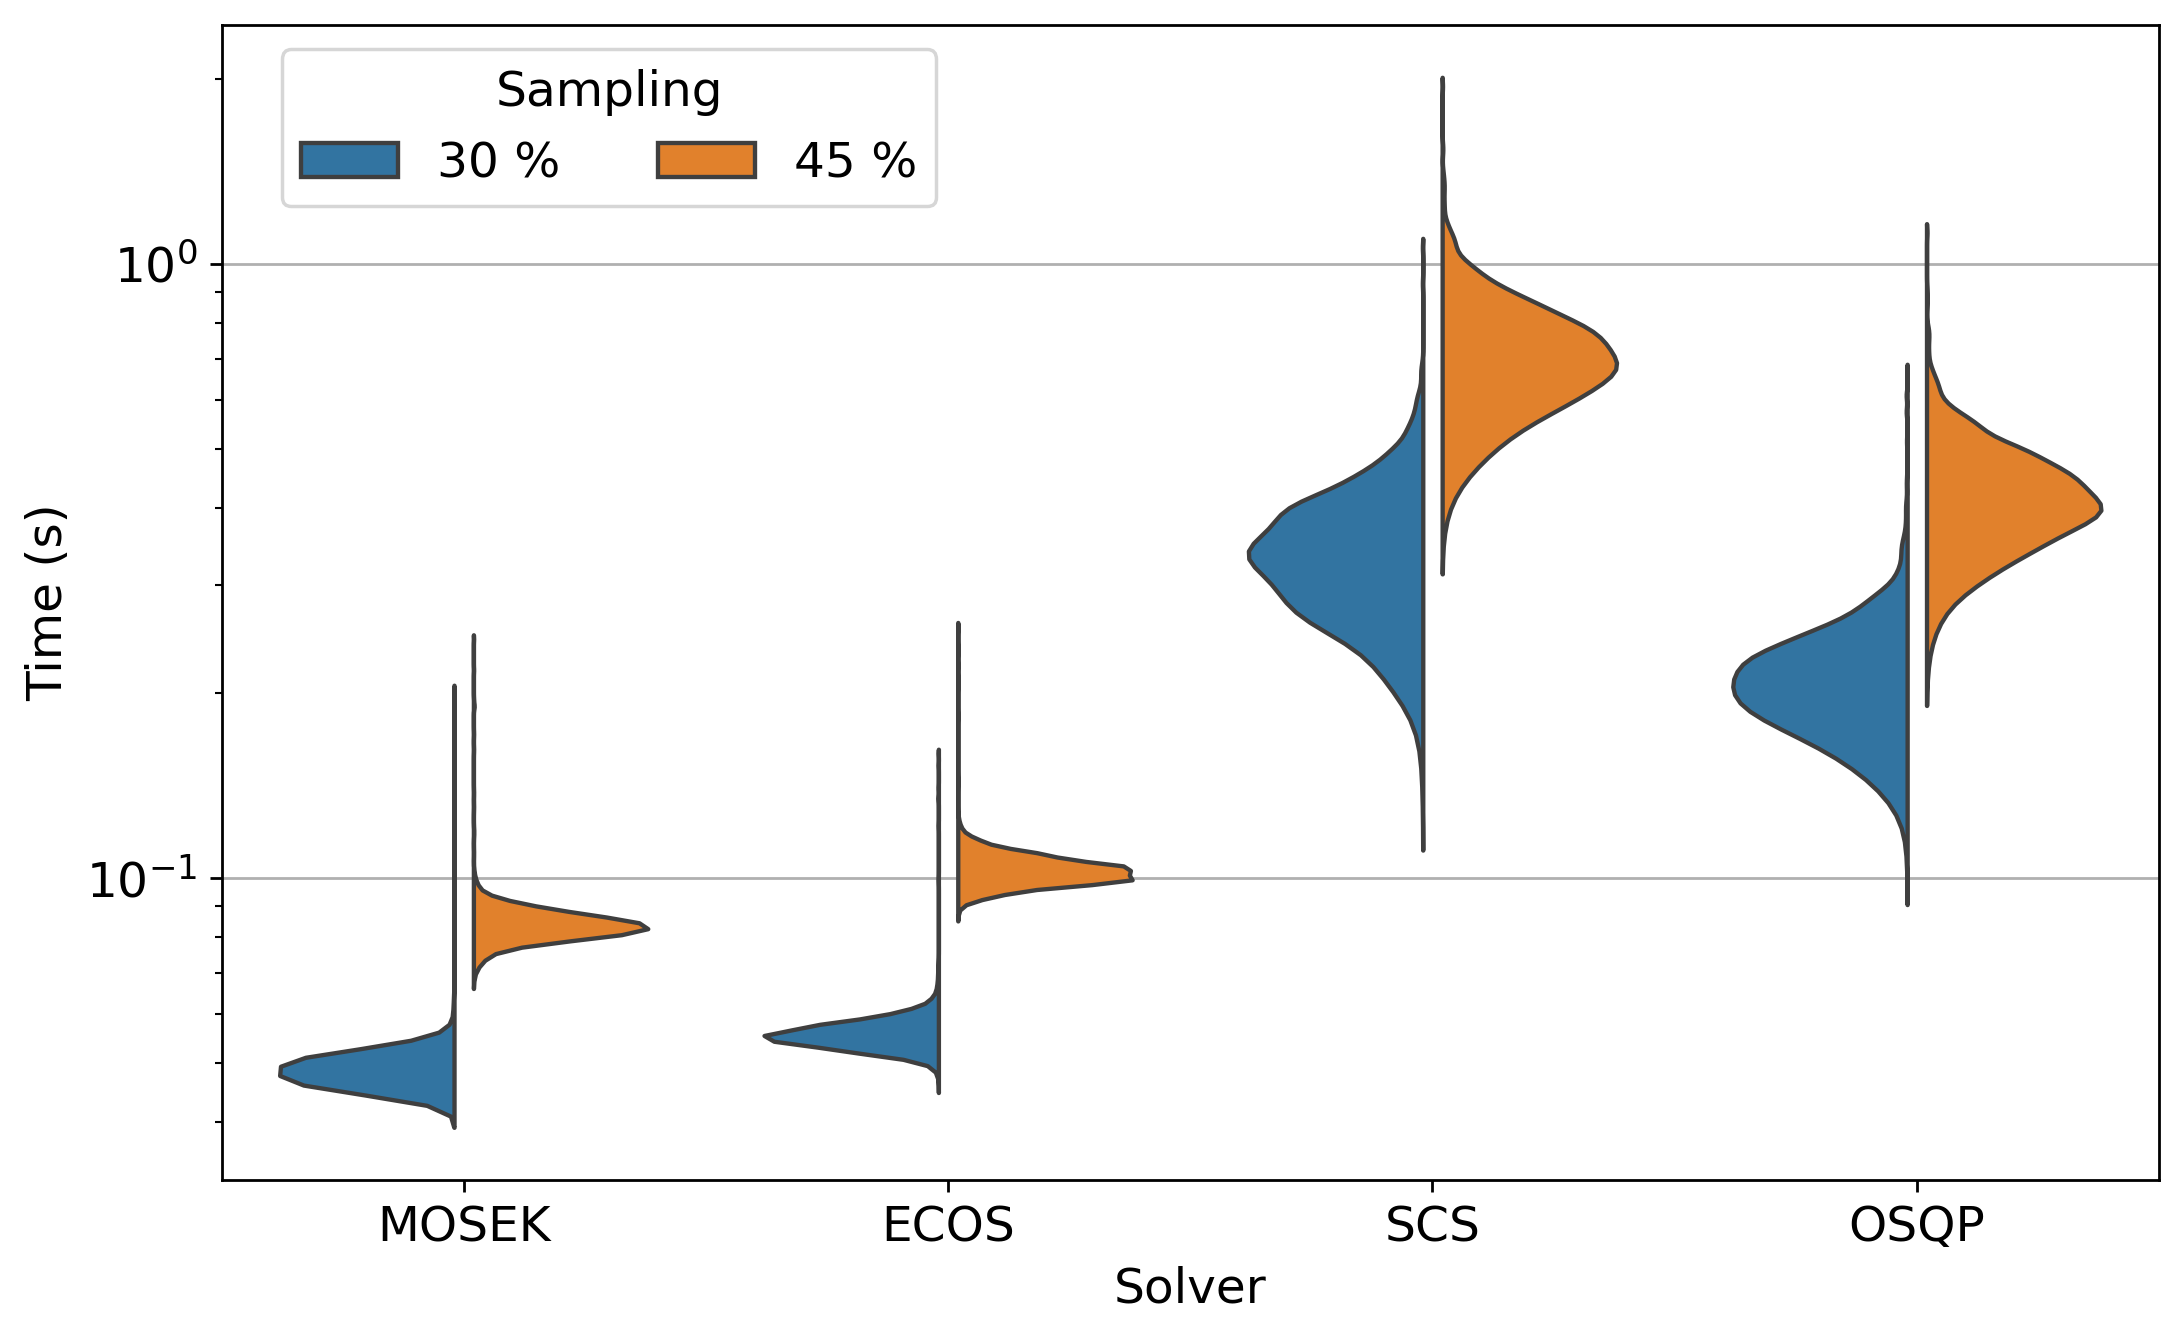

In [84]:
plt.figure(figsize=(10, 6), dpi=250)
plt.grid()
sns.violinplot(data=timeviolin, x='Solver', y ='Time', hue="Undersampling", gap=0.1, density_norm='count', split=True, inner=None)
# plt.text(0, 0.04, s='MMSE = 1.2^-3')
plt.xlabel('Solver', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.yscale('log')
plt.legend(title='Sampling', loc='upper center' , fontsize=14, title_fontsize=14,
           bbox_to_anchor=(0.2, 1), ncol=2, fancybox=True)
plt.rc('axes', axisbelow=True)
plt.savefig(f'./Figures/Time_violin.png', dpi=250)


In [328]:
thirty.keys()

dict_keys(['MOSEK', 'ECOS', 'SCS', 'OSQP'])

In [41]:
data = pd.DataFrame()
for methods in thirty.keys():
    temp = pd.DataFrame(np.array(thirty[methods]['Error']), columns=['Error'])
    temp['Solver'] = methods
    temp['Undersampling'] = '30 %'
    data = pd.concat([data, temp])

In [42]:
for methods in fortyfive.keys():
    temp = pd.DataFrame(np.array(fortyfive[methods]['Error']), columns=['Error'])
    temp['Solver'] = methods
    temp['Undersampling']  = '45 %'
    data = pd.concat([data, temp])

In [43]:
data.reset_index(inplace=True, drop=True)

In [44]:
data

,Error,Solver,Undersampling
0,0.000993,MOSEK,30 %
1,0.001019,MOSEK,30 %
2,0.001353,MOSEK,30 %
3,0.001336,MOSEK,30 %
4,0.001407,MOSEK,30 %
...,...,...,...
15995,0.000734,OSQP,45 %
15996,0.000186,OSQP,45 %
15997,0.000159,OSQP,45 %
15998,0.000239,OSQP,45 %


In [125]:
# make sure version is 0.13.0
sns.__version__

'0.13.0'

In [51]:
# make sure there are all calculations
data.groupby(['Undersampling', 'Solver']).count()

Error
Undersampling Solver       
30 %          ECOS     2000
              MOSEK    2000
              OSQP     2000
              SCS      2000
45 %          ECOS     2000
              MOSEK    2000
              OSQP     2000
              SCS      2000

In [381]:
# normalize to percentage
data['Error'] = data['Error'].apply(lambda x: x*100)

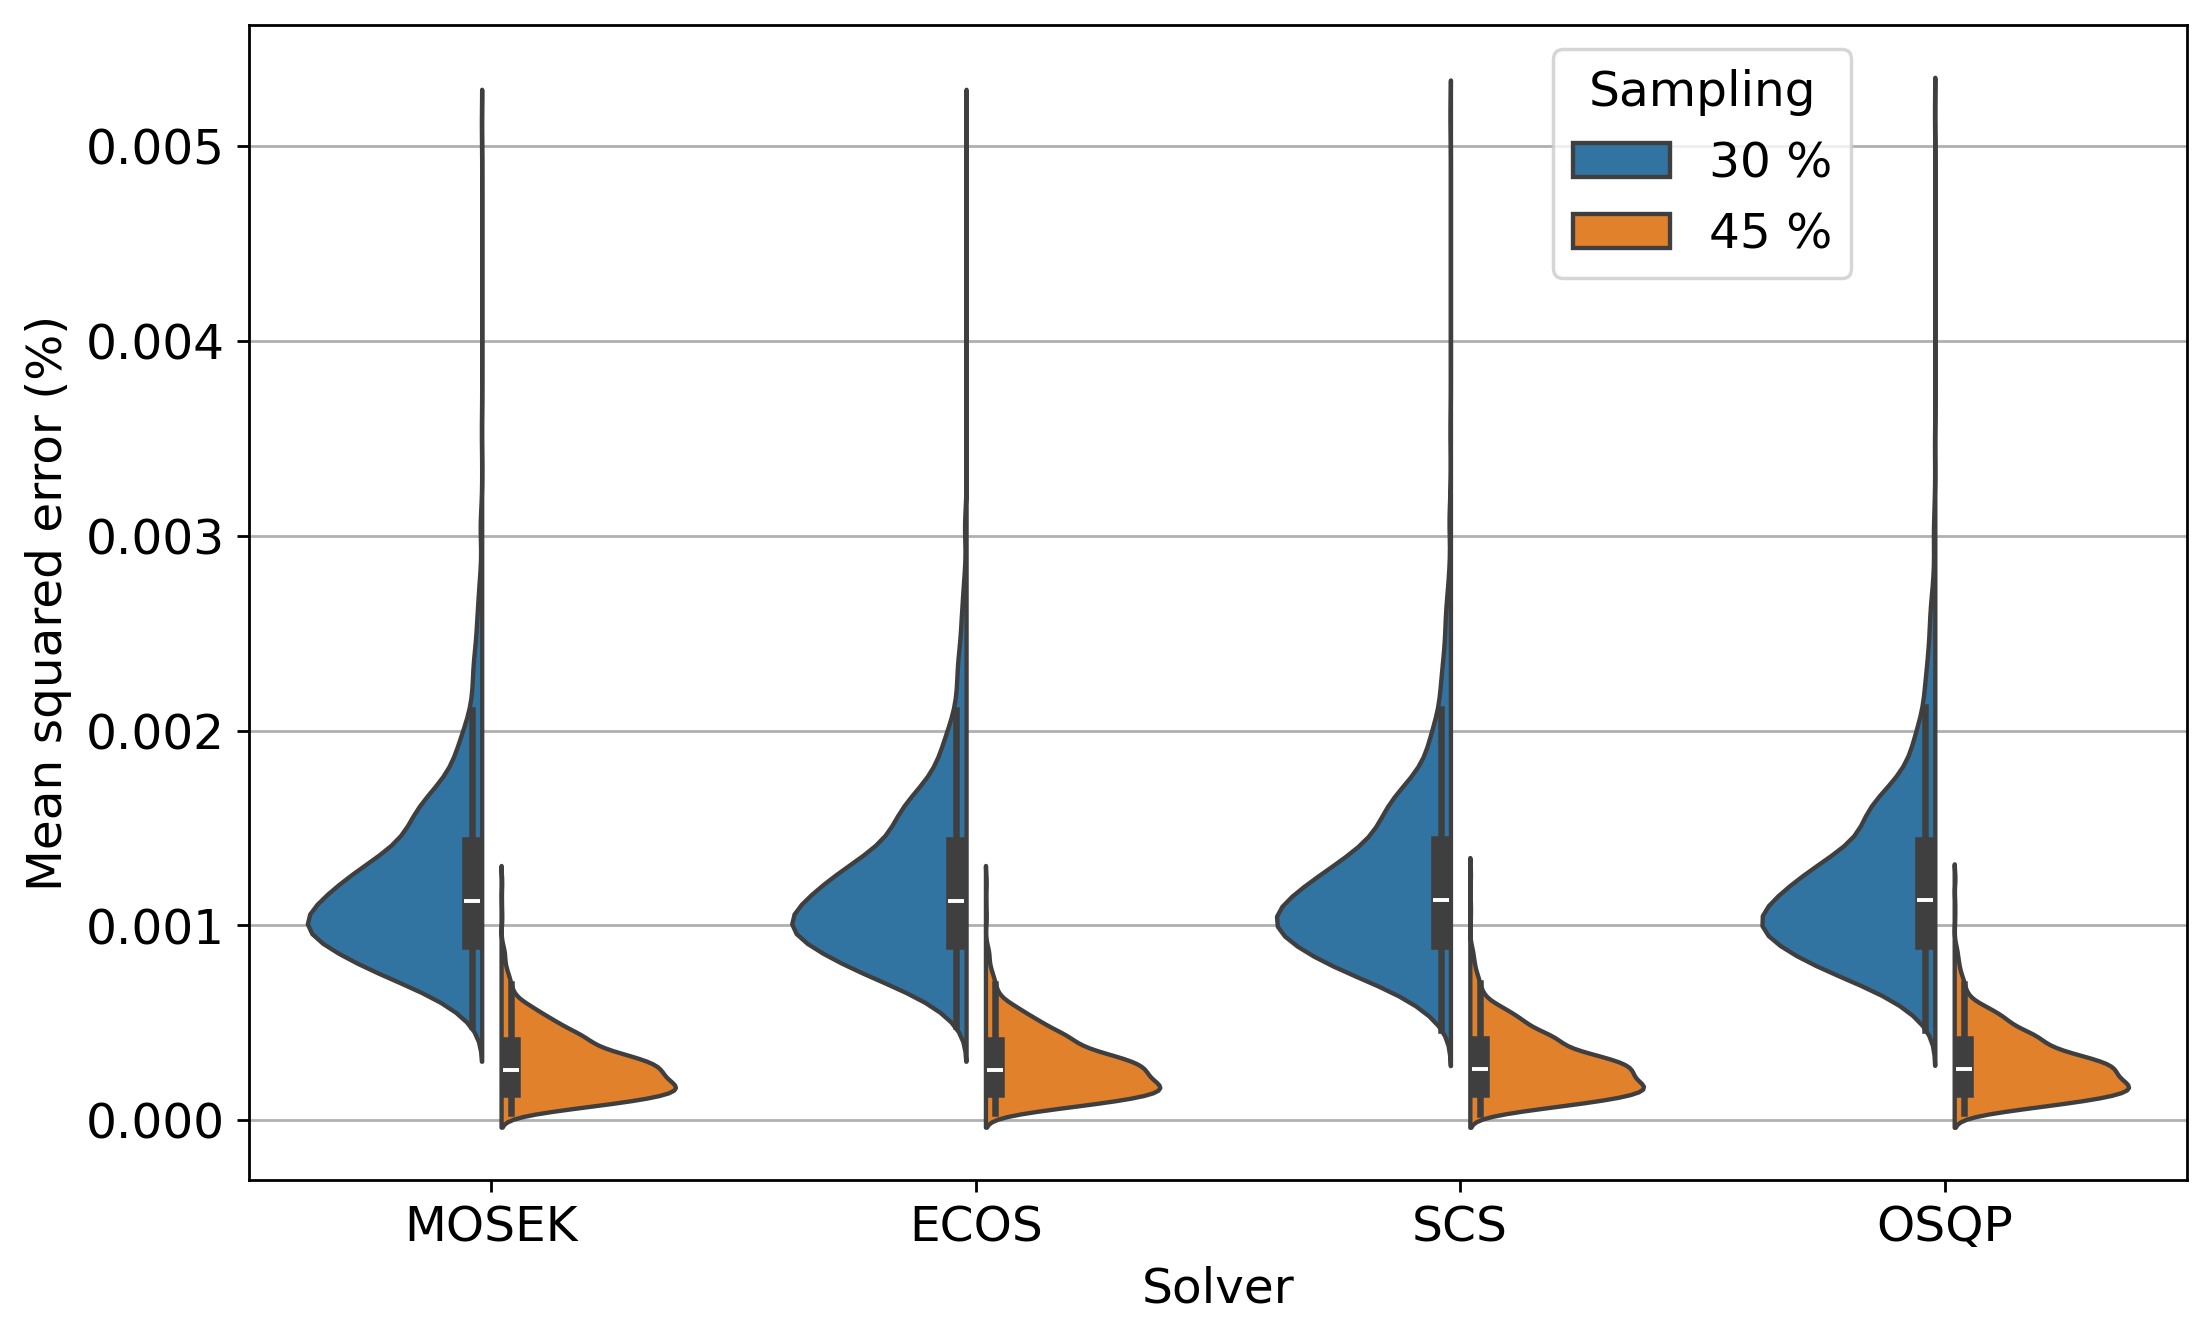

In [57]:
plt.figure(figsize=(10, 6), dpi=250)
plt.grid()
sns.violinplot(data=data, x='Solver', y ='Error', hue="Undersampling", gap=0.1,
               split=True, density_norm='area', common_norm=False)
plt.xlabel('Solver', fontsize=14)
plt.ylabel('Mean squared error (%)', fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(title='Sampling', loc='upper center' , fontsize=14, title_fontsize=14,
           bbox_to_anchor=(0.75, 1), ncol=1, fancybox=True)
plt.rc('axes', axisbelow=True)
plt.savefig(f'./Figures/Error_violin.png', dpi=250)